In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from msc_filtering import MyKalmanFilterZeroOrder, MyKalmanFilterHigherOrder, run_filter

## Some theory

#### State space processes

The discrete linear time invariant (LTI) state-space process model defines the evolution of the state from time k−1 to time k  as:

$x_k=Fx_{k−1}+Bu_{k}+w_{k}$

$x$: state vector (n x 1)<br> 
$F$: state transition matrix (n x n) - $F = \frac{\partial f(x)}{\partial x}$ <br> 
$u$: control vector <br> 
$B$: control-input matrix <br> 
$w$: process noise vector (n x 1) $w \sim N(0,Q)$ -> $Q$ (n x n)

The measurement/observation model describes the relationship between the state and the measurement at the current time step $k$

$z_k=Hx_{k}+{\upsilon}_k$

$z$: measurement vector. This is the measured value (m x 1) <br> 
$H$: measurement matrix (m x n)<br> 
$\upsilon$: measurement noise vector (m x 1) $\upsilon \sim N(0,R)$ -> $R$ (m x m)

$F$ is a discretised process which can be found from a continous linear first order state space model using the infinite sum:

From: <br>
$\dot{x} = A \cdot x $

One can find:<br>
$F_t = e^{{\Delta}tA} = I + \sum_{i=1}^{\infty}\frac{{\Delta}t^iA^i}{i!} $ <br>
- Where $I$ is the identity matrix
- $x_1 = x_0 e^{A{\Delta}t}$ is the solution to a first order differential equation
- Using Taylor series expansion:
$e^x= 1 + \sum_{i=1}^{\infty}\frac{x^i}{i!} $ -> describes/approximates the local region around a function with a differentiable polynomial

If you take a differential equation and discretize it in order to solve it numerically you will end up with a difference equation (difference between two consecutive values - can use to create a corresponding recursive equation) 

Note the similarities to the Newtonian equations: <br>
Constant velocity model: <br>
$x_t = x_{t-1} + v\Delta t$ <br>
$v_t = v_{t-1}$ <br>
Constant accelleration model: <br>
$x_t = \frac{1}{2}at^2+v_0t+x_0$ <br>

#### Standard kalman filter

Initialise: <br>
$x_{0|0}$ -> The "previous value of x" initialised to the starting value <br>
$P_{0|0}$ -> The error covariance (Uncertainty of the estimate). Variance is $\sigma^2$ <br>
When a relatively large error covaraiance is used for initialisation, the system tends towards using the first measurement as the new state (rather than the initial value of x) and converges over time. 

Prediction from action model: <br>
$x_{t|t-1}=Fx_{t-1|t-1}+Bu_{t|t}$ -> The expected value of x (intermediate) <br>
$P_{t|t-1}=FP_{t-1|t−1}F^T+Q$ -> The uncertainty of the estimate growth by dynamics and noise. <br>
Where $x_{t-1|t-1}$ is known as the prior estimate

Compute optimal Kalman gain: <br>
$K = P_{t|t-1}H^T(HP_{t|t-1}H^T+R)^{-1}$ -> (n x m) Trade off between prediction and measurements. Relatively large measurement noise leads to smaller gain. 

Correction from sensor: <br>
$x_{t|t}=x_{t|t−1}+K(z_t-Hx_{t|t-1})$ -> Lower gain emphesizes measurements less. The measurement residual is also known as the "innovation" term, which is the difference between the actual measurement and the expected measurement <br>
$P_{t|t}=(I-KH)P_{t|t-1}$ -> The uncertainty estimate shrinks based on observations. This is the variance of the optimium combined estimate. This gives the theoretical performance assuming all inputs and assumptions are accurate - however does not reflect the actual performance

Order refers to the number of derivatives needed to model the system accurately. When the Kalman filter is of higher order than your physical process it also has an infinite number of solutions that is can converge to (overfitting) which can lead to diverging behavior therefore the filter order should correspond to the problem. Adaptive filters adapt to changing order in an objects behavior.

## Try Kalman filtering

####  Constant process with zero order filter (constant model)

Ball with constant position at L=1m

In [2]:
measure_list_1 = [0.9, 0.8, 1.1, 1, 0.95, 1.05, 1.2, 0.9, 0.85, 1.15]

Define kalman filter params

In [3]:
x0 = 0  # Initial value - arbitrary guess
p0 = 1000  # State covariances (Error of estimation) - Init high since unknown
Q = 0.0001  # System noise
R = 0.1  # Measurement noise

Instantiate filter

In [4]:
zeroFilter_const = MyKalmanFilterZeroOrder(x0, p0, R, Q)
df_level = run_filter(zeroFilter_const, measure_list_1)
df_level

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,0.000000,1000.000100,0.999900,0.899910,0.099990
1,0.899910,0.100090,0.500225,0.849933,0.050022
2,0.849933,0.050122,0.333877,0.933424,0.033388
3,0.933424,0.033488,0.250867,0.950126,0.025087
4,0.950126,0.025187,0.201193,0.950101,0.020119
5,0.950101,0.020219,0.168187,0.966902,0.016819
6,0.966902,0.016919,0.144705,1.000633,0.014470
7,1.000633,0.014570,0.127175,0.987835,0.012717
8,0.987835,0.012817,0.113613,0.972175,0.011361
9,0.972175,0.011461,0.102827,0.990460,0.010283


Check results

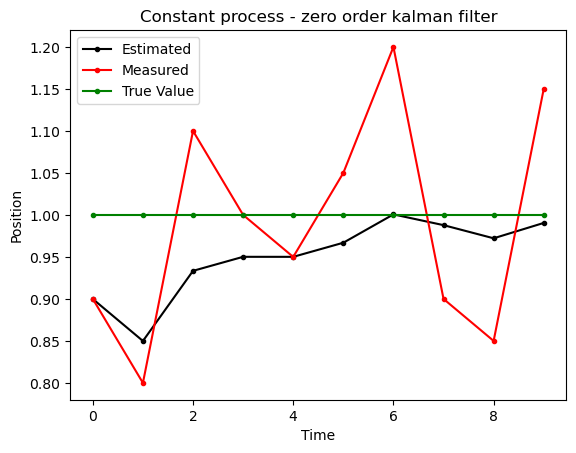

In [5]:
plt.plot(df_level.index, df_level['xt_curr'] ,marker=".",color="black")
plt.plot(df_level.index, measure_list_1 ,marker=".",color="red")
plt.plot(df_level.index, np.ones(len(df_level.index)) ,marker=".",color="g")
plt.title("Constant process - zero order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()

#### Constant increasing process with zero order filter

Ball with constant motion 0.1 per step

In [6]:
rising_zero_gt = np.arange(1,7)*0.1
rising_zero_gt

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

In [7]:
measure_list_2 = [0.11, 0.29, 0.32, 0.5, 0.58, 0.54]

Define kalman filter params

In [8]:
x0 = 0  # Initial value - arbitrary guess
p0 = 1000  # State covariances (Error of estimation) - High since unknown
Q = 0.001  # System noise
R = 0.1  # Measurement noise

Instantiate filter

In [9]:
zeroFilter_rising = MyKalmanFilterZeroOrder(x0, p0, R, Q)
df_rising_zero = run_filter(zeroFilter_rising, measure_list_2)
df_rising_zero

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,0.000000,1000.001000,0.999900,0.109989,0.099990
1,0.109989,0.100990,0.502463,0.200438,0.050246
2,0.200438,0.051246,0.338827,0.240949,0.033883
3,0.240949,0.034883,0.258615,0.307943,0.025861
4,0.307943,0.026861,0.211739,0.365548,0.021174
5,0.365548,0.022174,0.181494,0.397210,0.018149


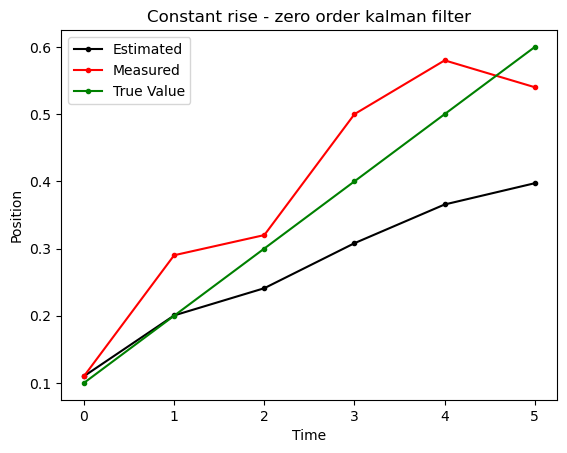

In [10]:
plt.plot(df_rising_zero.index, df_rising_zero['xt_curr'] ,marker=".",color="black")
plt.plot(df_rising_zero.index, measure_list_2 ,marker=".",color="red")
plt.plot(df_rising_zero.index, rising_zero_gt ,marker=".",color="g")
plt.title("Constant rise - zero order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()

Because the filter model assumes that there will be no change, the filter lags behind. There are no enough terms in the model to allow it to "catch up". Increasing the sampling rate can help.

#### Constant increasing process with first order filter (aka constant velocity model)

Using a sampling rate of $\Delta t= 1$

In [11]:
delta_t = 1

In [12]:
X0 = np.array([0,0])  # position, velocity
P0 = np.array([[1000,0],[0, 1000]])  # Assume no correlation between states
F = np.array([[1, delta_t], [0, 1]])
r = 0.3
q = 0.00001
Q = np.array([[((delta_t**3)*q)/3,((delta_t**2)*q)/2],
              [((delta_t**2)*q)/2,((delta_t)*q)]])
H = np.array([1, 0])

In [13]:
firstFilter_rising = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H)
df_rising_first = run_filter(firstFilter_rising,measure_list_2)
df_rising_first

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,"[0.0, 0.0]","[[2000.0000033333333, 1000.000005], [1000.0000...","[0.9998500224968755, 0.4999250129148544]","[0.10998350247465631, 0.054991751420633984]","[[0.2999550067489447, 0.14997750387439737], [0..."
1,"[0.1649752538952903, 0.054991751420633984]","[[0.7498908524553577, 0.29996000849868226], [0...","[0.7142560111859283, 0.2857058977103878]","[0.25427493034757365, 0.09071205874249337]","[[0.21427680335577842, 0.08571176931311632], [..."
2,"[0.34498698909006703, 0.09071205874249337]","[[0.4285617031589566, 0.1285747971567285], [0....","[0.5882297975597183, 0.17647756751314753]","[0.33028889755599, 0.08630241568840079]","[[0.1764689392679155, 0.052943270253944255], [..."
3,"[0.4165913132443908, 0.08630241568840079]","[[0.3000105896125172, 0.07060004675732409], [0...","[0.5000088245213505, 0.11766466789014028]","[0.4582963926639325, 0.09611667111465229]","[[0.15000264735640517, 0.035299400367042086], ..."
4,"[0.5544130637785848, 0.09611667111465229]","[[0.22943551381878877, 0.04413513276200815], [...","[0.4333587525398197, 0.08336262228361659]","[0.5655013865408132, 0.09824966521427311]","[[0.1300076257619459, 0.025008786685084973], [..."
5,"[0.6637510517550863, 0.09824966521427311]","[[0.18503805609819438, 0.030023310317830176], ...","[0.3814918309435374, 0.061898875645650484]","[0.61654103643985, 0.09058961425066657]","[[0.11444754928306122, 0.018569662693695147], ..."


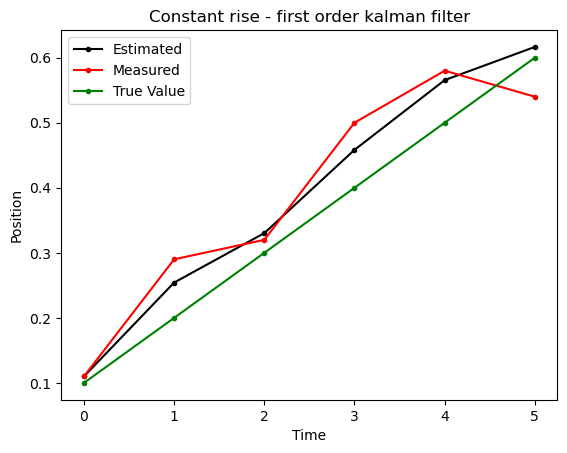

In [14]:
plt.plot(df_rising_first.index, np.stack((df_rising_first['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(df_rising_first.index, measure_list_2 ,marker=".",color="red")
plt.plot(df_rising_first.index, rising_zero_gt ,marker=".",color="g")
plt.title("Constant rise - first order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()

When P is initialised high - the measurements are used rather then the proposed initial values

#### Parabolic process with first order filter

$x_t = \frac{1}{2}at^2+v_0t+x_0$ <br>

In [15]:
crossover = 50
para_steps = np.arange(crossover+11)
para_gt = np.abs(0.5*(-10)*(para_steps**2)+5*crossover*para_steps)
para_measure = para_gt+500*(np.random.rand(para_gt.shape[0])-0.5)

Using a sampling rate of $\Delta t= 1$

In [16]:
delta_t = 1

In [17]:
X0 = np.array([0,0])  # position, velocity
P0 = np.array([[1000,0],[0, 1000]])  # Assume no correlation between states
F = np.array([[1, delta_t], [0, 1]])
r = 0.3
q = 0.001
Q = np.array([[((delta_t**3)*q)/3,((delta_t**2)*q)/2],
              [((delta_t**2)*q)/2,     ((delta_t)*q)]])
H = np.array([1, 0])

In [18]:
firstFilter_para = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H)
df_para_first = run_filter(firstFilter_para,para_measure)
df_para_first

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,"[0.0, 0.0]","[[2000.0003333333334, 1000.0005], [1000.0005, ...","[0.999850022521618, 0.4999251779024516]","[28.922276662990527, 14.461143151873904]","[[0.29995500675642983, 0.1499775533707077], [0..."
1,"[43.38341981486443, 14.461143151873904]","[[0.7502210751906254, 0.30045518173015456], [0...","[0.7143458581370146, 0.28608755701804883]","[48.56113220774277, 16.534759275699074]","[[0.2143037574411044, 0.08582626710541465], [0..."
2,"[65.09589148344185, 16.534759275699074]","[[0.4294170098547936, 0.1294536519749412], [0....","[0.5887126349579899, 0.17747550471946325]","[171.6135222493977, 48.64596117483691]","[[0.17661379048739695, 0.05324265141583897], [..."
3,"[220.25948342423462, 48.64596117483691]","[[0.3015814625015905, 0.07189168726502121], [0...","[0.5013144209057027, 0.11950449231941075]","[504.2269537412542, 116.33878420225591]","[[0.1503943262717108, 0.035851347695823224], [..."
4,"[620.5657379435102, 116.33878420225591]","[[0.23197970302823745, 0.04590069572737013], [...","[0.43606871034311623, 0.08628279512561352]","[780.2040235392325, 147.92563545655005]","[[0.13082061310293486, 0.02588483853768405], [..."
...,...,...,...,...,...
56,"[358.0702834998252, -55.642260367046255]","[[0.09922580309883712, 0.014176100195011147], ...","[0.2485455657641237, 0.03550897783904399]","[671.156900326028, -10.912491383223049]","[[0.07456366972923711, 0.010652693351713198], ..."
57,"[660.244408942805, -10.912491383223049]","[[0.09922579637459815, 0.014176099960314485], ...","[0.24854555310722817, 0.03550897784924922]","[991.4780396935796, 36.40989081277366]","[[0.07456366593216845, 0.010652693354774766], ..."
58,"[1027.8879305063533, 36.40989081277366]","[[0.09922579276274253, 0.01417610014246597], [...","[0.24854554630870712, 0.03550897862676609]","[1358.7260233422662, 83.67576598898452]","[[0.07456366389261213, 0.010652693588029824], ..."
59,"[1442.4017893312507, 83.67576598898452]","[[0.09922579135162744, 0.014176100537652158], ...","[0.24854554365259435, 0.03550897974215856]","[1757.9124067688253, 128.75185127453068]","[[0.07456366309577832, 0.010652693922647567], ..."


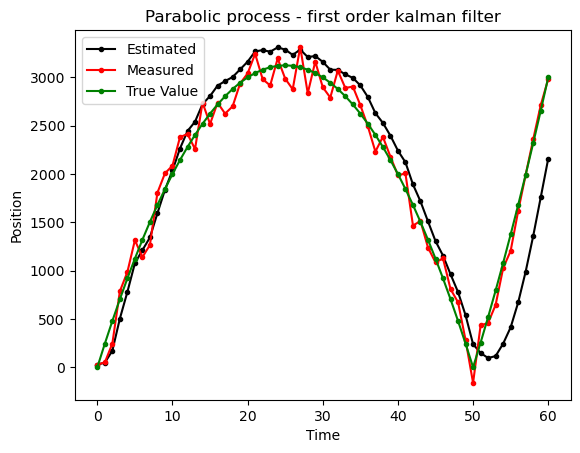

In [19]:
plt.plot(df_para_first.index, np.stack((df_para_first['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(para_steps, para_measure ,marker=".",color="red")
plt.plot(para_steps, para_gt ,marker=".",color="g")
plt.title("Parabolic process - first order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()

The first order kalman filter shows some overshoot as well as a general lag in responce. The lag can once again be addressed by increasing the sampling rate so that the velocity of each step is almost constant. Adding velocity correction measurements could also help

#### Parabolic process with second order filter (aka constant acceleration model)

In [20]:
delta_t = 1

In [21]:
X0 = np.array([0,0,0])  # position, velocity, acceleration
P0 = np.array([[1000,    0,   0],
               [0   , 1000,   0],
               [0   ,    0,1000]])  # Assume no correlation between states
F = np.array([[1, delta_t, 0.5*delta_t**2], 
              [0,       1,        delta_t],
              [0,       0,              1]])
r = 0.3
q = 0.001
Q = q*np.array([[(delta_t**4)/4,(delta_t**3)/2,(delta_t**2)/2],
                [(delta_t**3)/2,  (delta_t)**2,       delta_t],
                [(delta_t**2)/2,       delta_t,              1]])
H = np.array([1, 0, 0])

In [22]:
secondFilter_para = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H)
df_para_second = run_filter(secondFilter_para, para_measure)
df_para_second

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,"[0.0, 0.0, 0.0]","[[2250.00025, 1500.0005, 500.0005], [1500.0005...","[0.9998666844568852, 0.6665779377663047, 0.222...","[28.92275863637722, 19.2818433757708, 6.427285...","[[0.2999600053371815, 0.19997338132996872, 0.0..."
1,"[51.41824471720282, 25.709128785880388, 6.4272...","[[1.2000904212953554, 0.8003937919509609, 0.26...","[0.8000120554460013, 0.5335636976201783, 0.178...","[50.78892494613588, 25.289407380746358, 6.2872...","[[0.2400036166338005, 0.16006910928605356, 0.0..."
2,"[79.22193404217326, 31.57661081132841, 6.28720...","[[0.8075609103736313, 0.4412150855448552, 0.12...","[0.7291345359066562, 0.3983664297036386, 0.109...","[200.8467560183362, 98.02696216347915, 24.4921...","[[0.21874036077199685, 0.11950992891109159, 0...."
3,"[311.11980706636274, 122.51913993257392, 24.49...","[[0.5873869399892346, 0.26229546426031775, 0.0...","[0.6619287635632326, 0.29558183971413843, 0.06...","[625.9235426016351, 263.09358301539066, 56.144...","[[0.19857862906896984, 0.08867455191424155, 0...."
4,"[917.0892315857673, 319.2377949528737, 56.1442...","[[0.4495818989306369, 0.16847203496832594, 0.0...","[0.5997768883854001, 0.22475467351689032, 0.04...","[958.8107141338611, 334.87210559458686, 59.137...","[[0.17993306651562005, 0.06742640205506709, 0...."
...,...,...,...,...,...
56,"[1130.1458057034374, 249.00242310222174, 55.23...","[[0.2168906577023948, 0.05900601041430033, 0.0...","[0.4196064573240398, 0.11415569141176789, 0.02...","[1334.7456635576034, 304.66467002054065, 65.32...","[[0.12588193719721194, 0.03424670742353037, 0...."
57,"[1672.0728010609957, 369.9896049862443, 65.324...","[[0.21689066595987838, 0.05900601168962835, 0....","[0.41960646659600087, 0.11415569205540355, 0.0...","[1806.7074908717689, 406.61753475742927, 71.96...","[[0.1258819399788003, 0.034246707616621075, 0...."
58,"[2249.307163360935, 478.5818102209036, 71.9642...","[[0.2168906682298667, 0.059006010866874736, 0....","[0.4196064691448699, 0.11415568996233871, 0.02...","[2295.3284306286496, 491.1020879196569, 74.233...","[[0.12588194074346093, 0.03424670698870161, 0...."
59,"[2823.5473966933164, 565.3358442096771, 74.233...","[[0.2168906666668555, 0.059006009068918584, 0....","[0.4196064673898341, 0.11415568682912382, 0.02...","[2776.6698733532353, 552.5826187719872, 71.922...","[[0.12588194021695023, 0.03424670604873714, 0...."


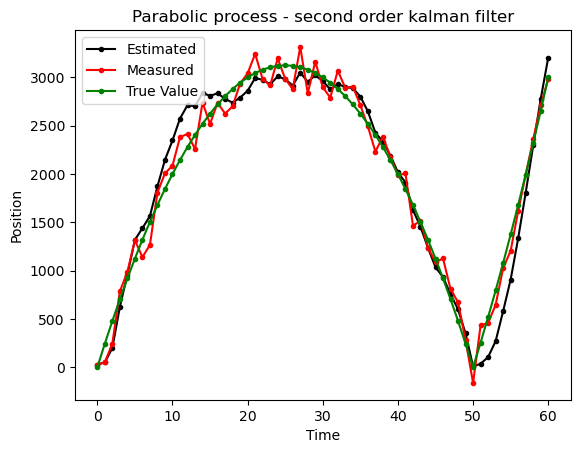

In [23]:
plt.plot(df_para_second.index, np.stack((df_para_second['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(df_para_second.index, para_measure ,marker=".",color="red")
plt.plot(df_para_second.index, para_gt ,marker=".",color="g")
plt.title("Parabolic process - second order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()

Second order filter tracks better and si more responcive but suppers higher sensitivity to noise from the displacement measurement that gets wrongly idenfitied as changes in acceleration

#### Parabolic process with first order filter and control input

We do however known the gravitational constant. Another approach is is to consider it as a control input

In [24]:
X0 = np.array([0,0])  # position, velocity
P0 = np.array([[1000,0],[0, 1000]])  # Assume no correlation between states
F = np.array([[1, delta_t], [0, 1]])
r = 0.3
q = 0.001
Q = np.array([[((delta_t**3)*q)/3,((delta_t**2)*q)/2],
              [((delta_t**2)*q)/2,     ((delta_t)*q)]])
H = np.array([1, 0])
B_ = np.array([[0, 0],[0, delta_t]])
u_ = np.array([0, -10])

In [25]:
contFilter_para = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H, B=B_,u=u_)
df_para_cont = run_filter(contFilter_para,para_measure)
df_para_cont

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,"[0, -10]","[[2000.0003333333334, 1000.0005], [1000.0005, ...","[0.999850022521618, 0.4999251779024516]","[28.922276662990527, 4.4611431518739035]","[[0.29995500675642983, 0.1499775533707077], [0..."
1,"[33.38341981486443, -5.5388568481260965]","[[0.7502210751906254, 0.30045518173015456], [0...","[0.7143458581370146, 0.28608755701804883]","[45.70459078911291, -0.6043651541204405]","[[0.2143037574411044, 0.08582626710541465], [0..."
2,"[45.10022563499247, -10.60436515412044]","[[0.4294170098547936, 0.1294536519749412], [0....","[0.5887126349579899, 0.17747550471946325]","[163.38955753032846, 25.05557763367268]","[[0.17661379048739695, 0.05324265141583897], [..."
3,"[188.44513516400113, 15.05557763367268]","[[0.3015814625015905, 0.07189168726502121], [0...","[0.5013144209057027, 0.11950449231941075]","[488.36159705559203, 86.55035819840381]","[[0.1503943262717108, 0.035851347695823224], [..."
4,"[574.9119552539959, 76.55035819840381]","[[0.23197970302823745, 0.04590069572737013], [...","[0.43606871034311623, 0.08628279512561352]","[754.4584269894196, 112.07634543120659]","[[0.13082061310293486, 0.02588483853768405], [..."
...,...,...,...,...,...
56,"[76.55227602977206, -135.6481504381832]","[[0.09922580309883712, 0.014176100195011147], ...","[0.2485455657641237, 0.03550897783904399]","[459.60894529540803, -80.92196476581404]","[[0.07456366972923711, 0.010652693351713198], ..."
57,"[378.686980529594, -90.92196476581404]","[[0.09922579637459815, 0.014176099960314485], ...","[0.24854555310722817, 0.03550897784924922]","[779.9004580567789, -33.601766081001045]","[[0.07456366593216845, 0.010652693354774766], ..."
58,"[746.2986919757778, -43.601766081001045]","[[0.09922579276274253, 0.01417610014246597], [...","[0.24854554630870712, 0.03550897862676609]","[1147.1245359369254, 13.663055347719357]","[[0.07456366389261213, 0.010652693588029824], ..."
59,"[1160.7875912846448, 3.6630553477193573]","[[0.09922579135162744, 0.014176100537652158], ...","[0.24854554365259435, 0.03550897974215856]","[1546.2921626760024, 58.73897348680666]","[[0.07456366309577832, 0.010652693922647567], ..."


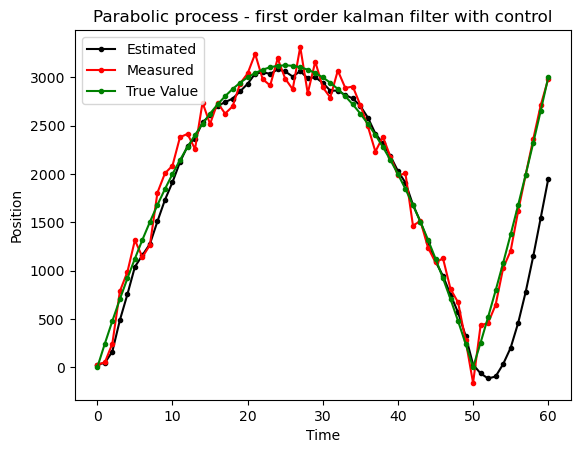

In [26]:
plt.plot(df_para_cont.index, np.stack((df_para_cont['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(para_steps, para_measure ,marker=".",color="red")
plt.plot(para_steps, para_gt ,marker=".",color="g")
plt.title("Parabolic process - first order kalman filter with control")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()

This is the best result seen yet when tracking the parabola, however it suffers greater lag on the rebound

####  Constant process with first order filter and control

Instantiate filter

In [27]:
measure_list_3 = [0.9, 0.8, 1.1, 1, 0.95, 1.05, 1.2, 0.9, 0.85, 1.15, 0.9, 0.8, 1.1, 1, 0.95, 1.05, 1.2, 0.9, 0.85, 1.15]

In [28]:
contFilter_const = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H, B=B_,u=u_)
df_const_cont = run_filter(contFilter_const,measure_list_1)
df_const_cont

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,"[0, -10]","[[2000.0003333333334, 1000.0005], [1000.0005, ...","[0.999850022521618, 0.4999251779024516]","[0.8998650202694563, -9.550067339887793]","[[0.29995500675642983, 0.1499775533707077], [0..."
1,"[-8.650202319618337, -19.550067339887793]","[[0.7502210751906254, 0.30045518173015456], [0...","[0.7143458581370146, 0.28608755701804883]","[-1.8994894340421702, -16.846482044941883]","[[0.2143037574411044, 0.08582626710541465], [0..."
2,"[-18.745971478984053, -26.846482044941883]","[[0.4294170098547936, 0.1294536519749412], [0....","[0.5887126349579899, 0.17747550471946325]","[-7.062397316290236, -23.324308240061114]","[[0.17661379048739695, 0.05324265141583897], [..."
3,"[-30.38670555635135, -33.324308240061114]","[[0.3015814625015905, 0.07189168726502121], [0...","[0.5013144209057027, 0.11950449231941075]","[-14.652097436231275, -29.573455926970517]","[[0.1503943262717108, 0.035851347695823224], [..."
4,"[-44.22555336320179, -39.57345592697052]","[[0.23197970302823745, 0.04590069572737013], [...","[0.43606871034311623, 0.08628279512561352]","[-24.525908069073758, -35.67558291144716]","[[0.13082061310293486, 0.02588483853768405], [..."
5,"[-60.201490980520916, -45.67558291144716]","[[0.18887273095210586, 0.0323339459781536], [0...","[0.38634335481192844, 0.06613980271548693]","[-36.53738446787389, -41.62442138196608]","[[0.11590300644357854, 0.019841940814646082], ..."
6,"[-78.16180584983996, -51.62442138196608]","[[0.16018458736517402, 0.024606306773616096], ...","[0.34808768429713066, 0.053470514765610905]","[-50.53693862993069, -47.38090477044666]","[[0.10442630528913918, 0.01604115442968327], [..."
7,"[-97.91784340037735, -57.38090477044666]","[[0.14027385248485855, 0.019973059432702767], ...","[0.31860591241830044, 0.04536508202787187]","[-66.4338942405914, -52.898025198771144]","[[0.09558177372549011, 0.013609524608361559], ..."
8,"[-119.33191943936254, -62.898025198771144]","[[0.12615403014132778, 0.0171293984741428], [0...","[0.29602918479848855, 0.04019532202584611]","[-83.75456380021042, -58.067274245221675]","[[0.08880875543954656, 0.012058596607753831], ..."
9,"[-141.8218380454321, -68.06727424522168]","[[0.11608915587068881, 0.015388470490055102], ...","[0.2790006762559482, 0.03698358938928342]","[-101.93259854520062, -62.779662492718295]","[[0.08370020287678445, 0.011095076816785026], ..."


Check results

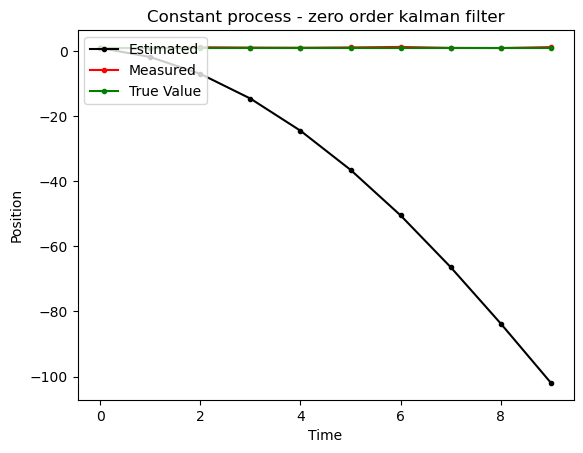

In [29]:
plt.plot(df_const_cont.index, np.stack((df_const_cont['xt_curr'].to_numpy()).tolist(), axis=0)[:,0] ,marker=".",color="black")
plt.plot(df_const_cont.index, measure_list_1 ,marker=".",color="red")
plt.plot(df_const_cont.index, np.ones(len(df_const_cont.index)) ,marker=".",color="g")
plt.title("Constant process - zero order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()

This model does however add error in other circumstances

#### Parabolic process with drag using order filter

"Wind" blowing in the negative direction (Acceleration constantly increasing in the negative direction)

In [30]:
delta_t = 1

In [41]:
def f_nonlin_step(pos_prev, vel_prev ,accel_prev):
    lambd = 1.02
    delta_t = 1
    
    accel_curr = accel_prev*lambd  # Non-linearity
    vel_curr = vel_prev + delta_t*accel_curr
    pos_curr = 0.5*accel_curr*(delta_t**2)+5*vel_curr*delta_t+pos_prev
    
    return pos_curr, vel_curr, accel_curr

In [42]:
samples = 35
wind_steps = np.arange(samples+1)
wind_gt = np.empty_like(wind_steps)
wind_accel = -10
wind_vel = 200

for step in wind_steps[1:]:
    wind_gt[step], wind_vel, wind_accel = f_nonlin_step(wind_gt[step-1], wind_vel, wind_accel)

# Add noise
wind_measure = wind_gt+2000*(np.random.rand(wind_gt.shape[0])-0.5)

In [43]:
contFilter_wind = MyKalmanFilterHigherOrder(X0, P0, r, Q, F, H, B=B_,u=u_)
df_wind_cont = run_filter(contFilter_wind,wind_measure)
df_wind_cont

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,"[0, -10]","[[2000.0003333333334, 1000.0005], [1000.0005, ...","[0.999850022521618, 0.4999251779024516]","[-556.6849497763453, -288.34256766898216]","[[0.29995500675642983, 0.1499775533707077], [0..."
1,"[-845.0275174453275, -298.34256766898216]","[[0.7502210751906254, 0.30045518173015456], [0...","[0.7143458581370146, 0.28608755701804883]","[-15.56178263710899, 33.84921730242155]","[[0.2143037574411044, 0.08582626710541465], [0..."
2,"[18.28743466531256, 23.84921730242155]","[[0.4294170098547936, 0.1294536519749412], [0....","[0.5887126349579899, 0.17747550471946325]","[1194.3510630284259, 378.38974120478537]","[[0.17661379048739695, 0.05324265141583897], [..."
3,"[1572.7408042332113, 368.38974120478537]","[[0.3015814625015905, 0.07189168726502121], [0...","[0.5013144209057027, 0.11950449231941075]","[1918.4193976054157, 450.7934046222472]","[[0.1503943262717108, 0.035851347695823224], [..."
4,"[2369.212802227663, 440.7934046222472]","[[0.23197970302823745, 0.04590069572737013], [...","[0.43606871034311623, 0.08628279512561352]","[2906.6035231064307, 547.1242932464381]","[[0.13082061310293486, 0.02588483853768405], [..."
5,"[3453.727816352869, 537.1242932464381]","[[0.18887273095210586, 0.0323339459781536], [0...","[0.38634335481192844, 0.06613980271548693]","[3361.5493994291164, 521.3438683108759]","[[0.11590300644357854, 0.019841940814646082], ..."
6,"[3882.8932677399926, 511.3438683108759]","[[0.16018458736517402, 0.024606306773616096], ...","[0.34808768429713066, 0.053470514765610905]","[4476.630748776136, 602.5491886333836]","[[0.10442630528913918, 0.01604115442968327], [..."
7,"[5079.17993740952, 592.5491886333836]","[[0.14027385248485855, 0.019973059432702767], ...","[0.31860591241830044, 0.04536508202787187]","[5180.141943417674, 606.924784018585]","[[0.09558177372549011, 0.013609524608361559], ..."
8,"[5787.0667274362595, 596.924784018585]","[[0.12615403014132778, 0.0171293984741428], [0...","[0.29602918479848855, 0.04019532202584611]","[5942.890673552804, 618.0828117237121]","[[0.08880875543954656, 0.012058596607753831], ..."
9,"[6560.973485276517, 608.0828117237121]","[[0.11608915587068881, 0.015388470490055102], ...","[0.2790006762559482, 0.03698358938928342]","[6549.054560387943, 606.5028706642275]","[[0.08370020287678445, 0.011095076816785026], ..."


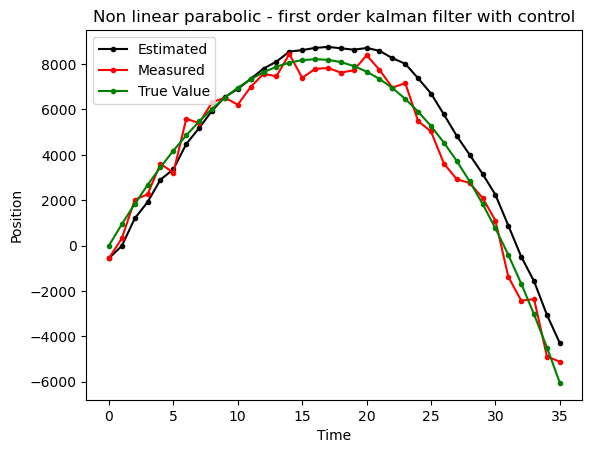

In [44]:
plt.plot(df_wind_cont.index, np.stack((df_wind_cont['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(wind_steps, wind_measure ,marker=".",color="red")
plt.plot(wind_steps, wind_gt ,marker=".",color="g")
plt.title("Non linear parabolic - first order kalman filter with control")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()

The standard Kalman filter however shoes lag in this case as it does not capture the non-linear shape well. As always, increasing the mangitude of process noise can help the estimates converge closer by weighing the measurements higher.

## More theory

#### Extended Kalman filter

For a nonlinear dynamic system - one is not able to define either or both the process model or measurement model with multiplication of vectors and matrices. In an EKF the models are linearized about a current estimate. The slope (first derviative) of a function gives a good linear approximation of the function in the local region (as per the first order of taylor series expansion)

The Jacobian matrix is a matrix containing the first-order partial derivatives of a function. Jacobian is the best linear approximation of the true gradient at a specific point.  Unless a linear function with and constant slope, the Jacobian will differ from point to point. 

A nonlinear process model: <br>
$x_t=f(x_{t−1},u_{t})+w_{t}$ <br>
$z_t=h(x_{t})+{\upsilon}_t$

Can be linearlized at a point using the first order taylor series expansion:<br>
$f(x_{k−1},u_{t}) \approx f(\mu_{t−1},u_{t}) + F_t(x_{t-1}-\mu_{t-1})$ <br>
$h(x_t) \approx h(\mu_{t}) + H_t(x_t-\mu_t)$ <br>
Where $\mu$ is the mean state which is the point where the linearization occurs

The following jacobians are computed and used in the standard update equations: <br>
$F_t = \frac{\partial f(\mu_{t-1}, u_{t})}{\partial x_{t-1}}$ <br>
$H_t = \frac{\partial h(\mu_{t})}{\partial x_t}$ <br>
The prediction step for $x_{t|t-1}$ and the predicted measurement in the innovation term can still be computed using the true functions.

#### Parabolic process with drag using EKF

In [ ]:
delta_t = 1

In [ ]:
X0 = np.array([0,0,0])  # Level, Filling rate
P0 = np.array([[1000,    0,   0],
               [0   , 1000,   0],
               [0   ,    0,1000]])  # Assume no correlation between states
F = np.array([[1, delta_t, 0.5*delta_t**2], 
              [0,       1,        delta_t],
              [0,       0,          lambd]])
r = 0.3
q = 0.0001
Q = q*np.array([[(delta_t**4)/4,(delta_t**3)/2,(delta_t**2)/2],
                [(delta_t**3)/2,  (delta_t)**2,       delta_t],
                [(delta_t**2)/2,       delta_t,              1]])
H = np.array([1, 0, 0])

In [ ]:
samples = 35
wind_steps = np.arange(samples+1)
wind_gt = np.empty_like(wind_steps)
wind_accel = -10
wind_vel = 200
lambd = 1.02

for step in wind_steps[1:]:
    wind_accel = wind_accel*lambd  # Non-linearity
    wind_vel = wind_vel + delta_t*wind_accel
    wind_gt[step] = 0.5*wind_accel*(delta_t**2)+5*wind_vel*delta_t+wind_gt[step-1]

# Add noise
wind_measure = wind_gt+2000*(np.random.rand(wind_gt.shape[0])-0.5)

In [ ]:
def f_nonlin_step(pos_prev, vel_prev ,accel_prev):
    lambd = 1.02
    delta_t = 1
    
    accel_curr = accel_prev*lambd
    vel_curr = vel_prev + delta_t*accel_curr
    accel_curr = 0.5*accel_curr*(delta_t**2)+5*vel_curr*delta_t+pos_prev
    
    return pos_curr, vel_curr, accel_curr

In [ ]:
EKFFilter_wind = MyKalmanFilterEKF(X0, P0, r, Q, F, H)
df_wind_EKF = run_filter(EKFFilter_wind, wind_measure)

In [ ]:
plt.plot(df_para_second.index, np.stack((df_para_second['xt_curr'].to_numpy()).tolist(), axis=0)[:,0],marker=".",color="black")
plt.plot(df_para_second.index, para_measure ,marker=".",color="red")
plt.plot(df_para_second.index, para_gt ,marker=".",color="g")
plt.title("Parabolic process - second order kalman filter")
plt.xlabel("Time")
plt.ylabel("Position")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()

Second order filter works significantly better but the model is not perfect

#### Parabolic process with drag and second order filter

For severly nonlinear systems - an unscented kalman filter (UKF) may work better.

## Bonus: Sensor fusion

There are various approaches that can be taken to fuse sensors. Some are:
- Merge with observation matrix
- Pre-combine with minimum meansquare estimates (equivalent to previous)
- Correction step performed per each sensor arrival -> Useful when at different sampling rates

#### Merge with observation matrix

Suppose you have two measurements for the state: <br>
$z = [x_A,x_B]^T $

The matrix H converts x to z measurements: <br>
$z_t=Hx_{t}$